In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tqdm import tqdm
import torch
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import Compose, Resize, Lambda, ToTensor, Grayscale, ToPILImage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('seaborn')
import PIL
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from CLIP import clip as clip_utils
from utils import load_datasets_ImageNet_two_transforms

torch.manual_seed(0)
np.random.seed(0)
rng = np.random.default_rng(0)

path_results = os.path.dirname(os.getcwd()) + '/results'
path_dataset = os.path.expandvars('$DSDIR/imagenet') # '/scratchf/'
path_imagenet_labels = os.path.expandvars('$WORK/DATA/LOC_synset_mapping.txt')
path_imagenet_categories = os.path.expandvars('$WORK/DATA/imagenet_categories_synset.csv')
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
BATCH_SIZE = 1024

In [3]:
# LOAD CLASSIFIER
weights = ResNet50_Weights.IMAGENET1K_V2
classifier = resnet50(weights=weights).to(device)
preprocess_classif = weights.transforms()
classifier.eval()

# LOAD CLIP
clip, preprocess_clip = clip_utils.load("ViT-B/16", device=device)

# LOAD DATA
dataset_train, dataset_val = load_datasets_ImageNet_two_transforms(path_dataset, BATCH_SIZE, preprocess_classif, preprocess_clip)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=False)   
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=False)
idx_to_label = {}
with open(path_imagenet_labels) as f:
    for i, line in enumerate(f):
       idx_to_label[i] = line[10:-1]
idx_to_category = {}
with open(path_imagenet_categories) as f:
    for i, line in enumerate(f):
       if i>0:
        idx_to_category[i-1] = line.split(',')[-1][:-1]

In [5]:
if os.path.exists(path_results + '/logs_classif_val.csv'):
    print('Load logs.')
    df = pd.read_csv(path_results + '/logs_classif_val.csv', index_col=0)

else:
    print('Compute classification logs.')
    df = pd.DataFrame(columns=['MSP', 'TCP', 'y_pred', 'y_true', 'well_classified', 'pred_in_top5'], index=pd.RangeIndex(len(dataset_val)))
    idx = 0
    for batch in tqdm(dataloader_val):
        (x_classif, y_classif), (x_clip, y_clip) = batch
        assert (y_classif == y_clip).all(), "data for classifier and CLIP is not the same"
        batch_size = x_classif.shape[0]
        x_classif = x_classif.to(device)
        y_classif = y_classif.to(device)

        with torch.no_grad():
            logits = classifier(x_classif)
        probas = torch.nn.functional.softmax(logits, dim=1)
        pred_top5 = logits.topk(5, dim=1).indices.t()

        df.loc[idx:idx+batch_size-1, 'MSP'] = probas.max(1).values.cpu()
        df.loc[idx:idx+batch_size-1, 'TCP'] = probas[torch.arange(batch_size), y_classif].cpu()
        df.loc[idx:idx+batch_size-1, 'y_pred'] = logits.argmax(dim=1).cpu()
        df.loc[idx:idx+batch_size-1, 'y_true'] = y_classif.cpu()
        df.loc[idx:idx+batch_size-1, 'well_classified'] = (logits.argmax(dim=1) == y_classif).cpu()
        df.loc[idx:idx+batch_size-1, 'pred_in_top5'] = pred_top5.eq(y_classif.expand_as(pred_top5)).sum(0).bool().cpu()

        idx += batch_size

    df.to_csv(path_results + '/logs_classif_val.csv')
    print('Classification logs saved')

Compute classification logs.


100%|██████████| 49/49 [04:22<00:00,  5.35s/it]


Classification logs saved


In [5]:
idx_errors_top1 = df.index[df['well_classified'] == False].tolist()
idx_errors_top5 = df.index[df['pred_in_top5'] == False].tolist()

dataset_val_errors_top1 = Subset(dataset_val, idx_errors_top1)
dataset_val_errors_top5 = Subset(dataset_val, idx_errors_top5)

# Examples of misclassified

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


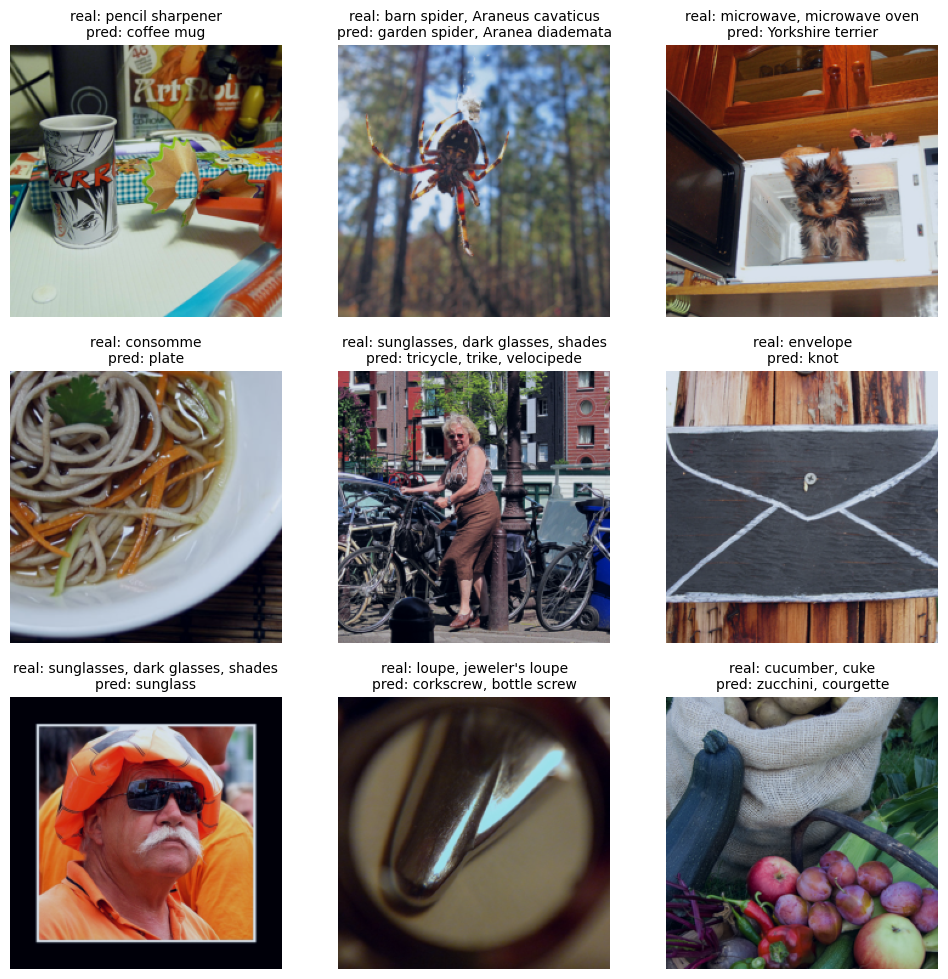

In [6]:
figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_val_errors_top1), size=(1,)).item()
    (img, label), _ = dataset_val_errors_top1[sample_idx]
    pred = classifier(img.to(device).unsqueeze(0)).argmax(dim=1).item()
    figure.add_subplot(rows, cols, i)
    plt.title(f'real: {idx_to_label[label]}\npred: {idx_to_label[pred]}', fontsize=10)
    plt.axis("off")
    plt.imshow((0.2*img+0.4).permute(1, 2, 0), cmap="gray")
plt.show()

# Selective classification

Text(0, 0.5, 'accuracy')

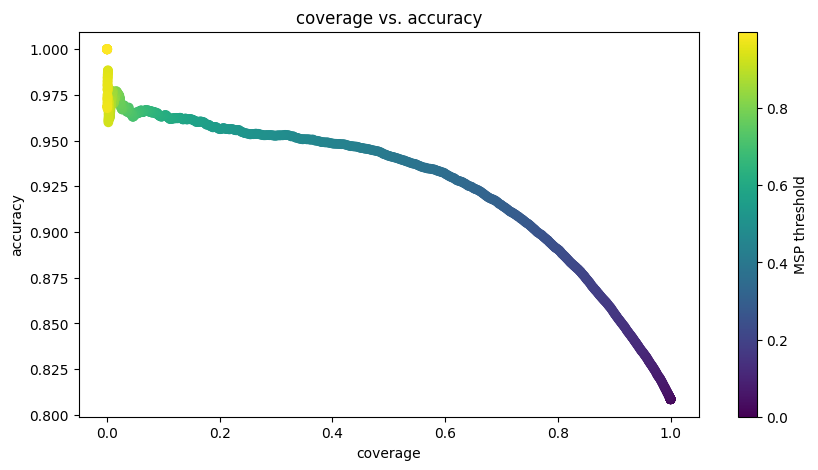

In [7]:
# baseline: max softmax
domain_cutoff_baseline = np.linspace(0, 1, 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
risk_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = df['MSP'] > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df.loc[idx_domain, 'well_classified'].mean()

# plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
sc = ax1.scatter(coverage_baseline, acc_baseline, c=domain_cutoff_baseline, cmap='viridis')
fig.colorbar(sc, ax=ax1, label='MSP threshold')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')

# Stats per class

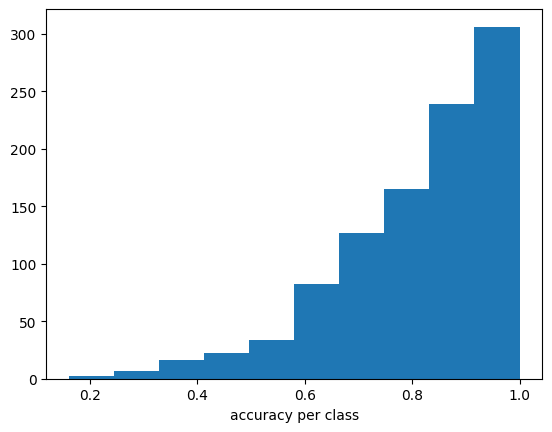

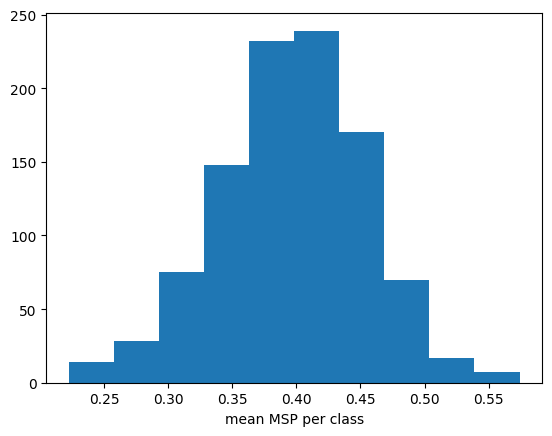

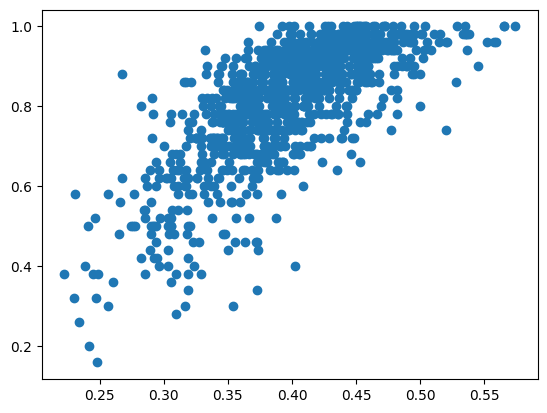

In [8]:
acc_per_class = []
mean_msp_per_class = []
for class_idx in range(1000):
    acc_per_class.append(df.loc[np.array(dataset_val.imagenet_data_1.targets) == class_idx, 'well_classified'].mean())
    mean_msp_per_class.append(df.loc[np.array(dataset_val.imagenet_data_1.targets) == class_idx, 'MSP'].mean())

plt.figure()
plt.hist(acc_per_class)
plt.xlabel('accuracy per class')

plt.figure()
plt.hist(mean_msp_per_class)
plt.xlabel('mean MSP per class')

plt.figure()
plt.scatter(mean_msp_per_class, acc_per_class)

# selective classif with attributes (from CLIP)

### tests

zero-shot classif: a photo taken outdoors


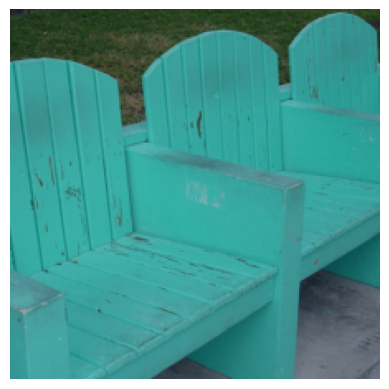

In [9]:
sample_idx = torch.randint(len(dataset_val_errors_top5), size=(1,)).item()
(img, label), (img_clip, _) = dataset_val_errors_top5[sample_idx]

# Prepare the inputs
image_input = img_clip.unsqueeze(0).to(device)
# prompts = ['a photo of a person', 'a photo of an animal', 'a photo of an object']
prompts = ['a photo taken indoors', 'a photo taken outdoors']
# prompts = ['a photo taken during daytime', 'a photo taken during night-time']
text_input = torch.cat([clip_utils.tokenize(p) for p in prompts]).to(device)

# Calculate features
with torch.no_grad():
    image_features = clip.encode_image(image_input)
    text_features = clip.encode_text(text_input)
    
# Similarity between images and text
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T)
# similarity = similarity / similarity.max()
print(f'zero-shot classif: {prompts[similarity.argmax()]}')

plt.figure()
plt.axis("off")
plt.imshow((0.2*img+0.4).permute(1, 2, 0), cmap="gray")

### on dataset

In [10]:
attributes = ['person', 'animal', 'object', 'objects', 'outdoors', 'night']
prompts = ['a photo of a person', 'a photo of an animal', 'a photo of an object', 'a photo of many objects', 'a photo taken outdoors', 'a photo taken during the night']
text_input = torch.cat([clip_utils.tokenize(p) for p in prompts]).to(device)

# for a in attributes:
#     df[f'similarity_{a}'] = 0
# idx = 0
# for batch in tqdm(dataloader_val):
#     (x_classif, y_classif), (x_clip, y_clip) = batch
#     assert (y_classif == y_clip).all(), "data for classifier and CLIP is not the same"
#     batch_size = x_classif.shape[0]
#     x_clip = x_clip.to(device)

#     with torch.no_grad():
#         image_features = clip.encode_image(x_clip)
#         text_features = clip.encode_text(text_input)
#     image_features /= image_features.norm(dim=-1, keepdim=True)
#     text_features /= text_features.norm(dim=-1, keepdim=True)
#     similarity = (100.0 * image_features @ text_features.T)

#     for i, a in enumerate(attributes):
#         df.loc[idx:idx+batch_size-1, f'similarity_{a}'] = similarity[:, i].cpu().numpy()

#     idx += batch_size    

# df.to_csv(path_results + '/logs_classif_val.csv')
# print('CLIP logs saved')

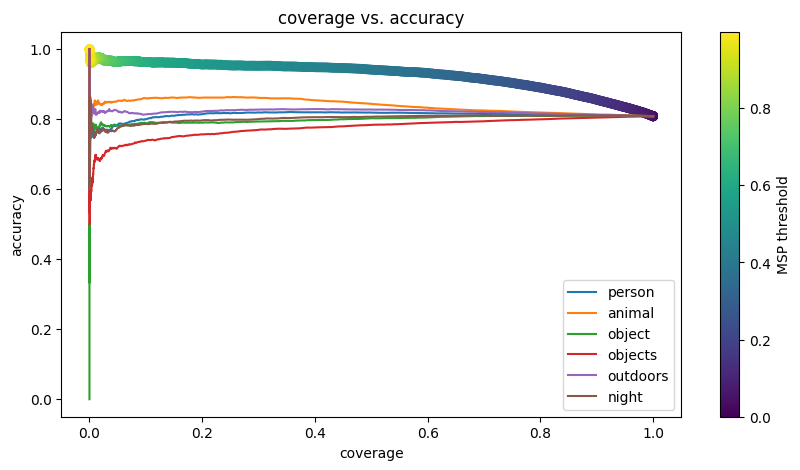

In [11]:
# baseline: max softmax
domain_cutoff_baseline = np.linspace(0, 1, 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
risk_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = df['MSP'] > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df.loc[idx_domain, 'well_classified'].mean()

# plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
sc = ax1.scatter(coverage_baseline, acc_baseline, c=domain_cutoff_baseline, cmap='viridis')
fig.colorbar(sc, ax=ax1, label='MSP threshold')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')


# using attribute
for a in attributes:
    domain_cutoff = np.linspace(df[f'similarity_{a}'].min(), df[f'similarity_{a}'].max(), 1000)
    coverage = np.zeros_like(domain_cutoff)
    risk = np.zeros_like(domain_cutoff)
    acc = np.zeros_like(domain_cutoff)
    for i, cut in enumerate(domain_cutoff):
        idx_domain = df[f'similarity_{a}'] > cut
        coverage[i] = idx_domain.mean()
        acc[i] = df.loc[idx_domain, 'well_classified'].mean()
    ax1.plot(coverage, acc, label=a)
plt.legend()


(array([7.0000e+00, 1.2300e+02, 1.6410e+03, 8.7100e+03, 1.8590e+04,
        1.4654e+04, 5.0810e+03, 1.0140e+03, 1.6300e+02, 1.7000e+01]),
 array([11.7421875 , 13.71953125, 15.696875  , 17.67421875, 19.6515625 ,
        21.62890625, 23.60625   , 25.58359375, 27.5609375 , 29.53828125,
        31.515625  ]),
 <BarContainer object of 10 artists>)

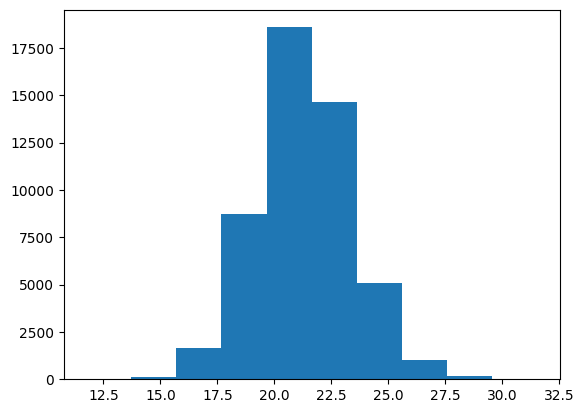

In [12]:
plt.figure()
plt.hist(torch.tensor(df[f'similarity_{a}'].to_numpy()))

### per class

In [13]:
all_y = np.zeros(50000)
idx = 0
for batch in tqdm(dataloader_val):
    (x_classif, y_classif), (x_clip, y_clip) = batch
    batch_size = y_classif.shape[0]
    all_y[idx:idx+batch_size] = y_classif
    idx += batch_size

100%|██████████| 49/49 [04:12<00:00,  5.15s/it]


446 binder, ring-binder


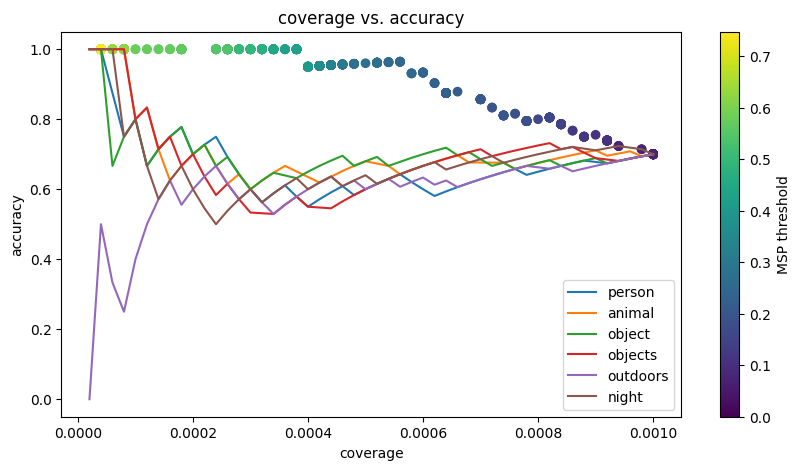

In [14]:
class_idx = torch.randint(1000, size=(1,)).item() # 999 toilet paper
is_class = all_y == class_idx
print(class_idx, idx_to_label[class_idx])

# baseline: max softmax
domain_cutoff_baseline = np.linspace(0, 1, 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
risk_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = (df['MSP'] > cut) & is_class
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df.loc[idx_domain, 'well_classified'].mean()

# plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
sc = ax1.scatter(coverage_baseline, acc_baseline, c=domain_cutoff_baseline, cmap='viridis')
fig.colorbar(sc, ax=ax1, label='MSP threshold')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')


# using attribute
for a in attributes:
    domain_cutoff = np.linspace(df[f'similarity_{a}'].min(), df[f'similarity_{a}'].max(), 1000)
    coverage = np.zeros_like(domain_cutoff)
    risk = np.zeros_like(domain_cutoff)
    acc = np.zeros_like(domain_cutoff)
    for i, cut in enumerate(domain_cutoff):
        idx_domain = (df[f'similarity_{a}'] > cut) & is_class
        coverage[i] = idx_domain.mean()
        acc[i] = df.loc[idx_domain, 'well_classified'].mean()
    ax1.plot(coverage, acc, label=a)
plt.legend()


### per category

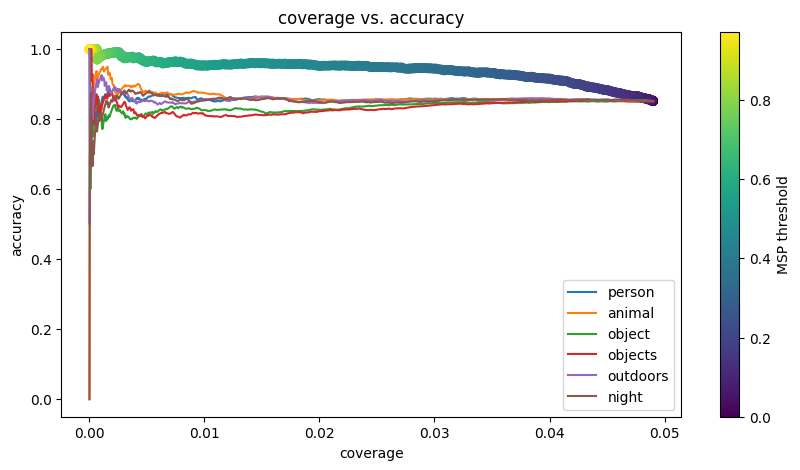

In [15]:
category = 'vehicle'
all_categories = np.array([idx_to_category[y] for y in all_y])
is_category = all_categories == category

# baseline: max softmax
domain_cutoff_baseline = np.linspace(0, 1, 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
risk_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = (df['MSP'] > cut) & is_category
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df.loc[idx_domain, 'well_classified'].mean()

# plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
sc = ax1.scatter(coverage_baseline, acc_baseline, c=domain_cutoff_baseline, cmap='viridis')
fig.colorbar(sc, ax=ax1, label='MSP threshold')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')


# using attribute
for a in attributes:
    domain_cutoff = np.linspace(df[f'similarity_{a}'].min(), df[f'similarity_{a}'].max(), 1000)
    coverage = np.zeros_like(domain_cutoff)
    risk = np.zeros_like(domain_cutoff)
    acc = np.zeros_like(domain_cutoff)
    for i, cut in enumerate(domain_cutoff):
        idx_domain = (df[f'similarity_{a}'] > cut) & is_category
        coverage[i] = idx_domain.mean()
        acc[i] = df.loc[idx_domain, 'well_classified'].mean()
    ax1.plot(coverage, acc, label=a)
plt.legend()


# selective classif from predicted class

In [25]:
def compute_subdomain_scores(df_calib, df_test, subdomain_attributes):

    print(subdomain_attributes) # ['world_name', 'character_scale', 'character_texture', 'camera_yaw', 'prediction']
    
    # learn subdomain perfo and rank subdomains
    df_subdomains = df_calib.groupby(subdomain_attributes).agg(count=('correct', 'size'), accuracy=('correct', 'mean')).reset_index()
    df_subdomains = df_subdomains.sort_values(by='accuracy', ascending=False).reset_index(drop=True)
    print(f'{len(df_subdomains)} subdomains')

    # assign value to subdomain according to rank in train
    df_test['subdomain_score'] = None
    for subdomain_idx, subdomain_score in enumerate(np.linspace(1, 0, len(df_subdomains))):
        idx = (df_test[subdomain_attributes].apply(tuple, 1) == df_subdomains[subdomain_attributes].apply(tuple, 1).iloc[subdomain_idx])
        df_test.loc[idx, 'subdomain_score'] = subdomain_score

    print(f"{df_test['subdomain_score'].isna().sum()} nan values (they appear because subdomains in test are not all included in train). Score set to 0.")
    df_test.loc[df_test['subdomain_score'].isna(), 'subdomain_score'] = 0

    print(f"AUROC baseline: {roc_auc_score(df_test['correct'].astype(float), df_test['confidence']):.3f}\nAUROC subdomains: {roc_auc_score(df_test['correct'].astype(float), df_test['subdomain_score']):.3f}")
    return df_test

df_calib, df_test = train_test_split(df.rename(columns={'well_classified': 'correct', 'MSP': 'confidence'}), test_size=0.5, random_state=0, shuffle=True, stratify=df['y_true'])
df_test = compute_subdomain_scores(df_calib, df_test, ['y_pred'])
df_test

['y_pred']
1000 subdomains
0 nan values (they appear because subdomains in test are not all included in train). Score set to 0.
AUROC baseline: 0.810
AUROC subdomains: 0.689


,confidence,TCP,y_pred,y_true,correct,pred_in_top5,subdomain_score
16789,0.496225,0.496225,335,335,True,True,0.71972
14694,0.57238,0.57238,293,293,True,True,0.672673
48511,0.590048,0.590048,970,970,True,True,0.076076
36342,0.567324,0.567324,726,726,True,True,0.732733
8289,0.201684,0.066236,236,165,False,True,0.57958
...,...,...,...,...,...,...,...
23163,0.305872,0.026197,840,463,False,True,0.409409
1300,0.395561,0.395561,26,26,True,True,0.303303
12756,0.414416,0.414416,255,255,True,True,0.94995
43719,0.402365,0.402365,874,874,True,True,0.562563


(0.0001, 1.0)

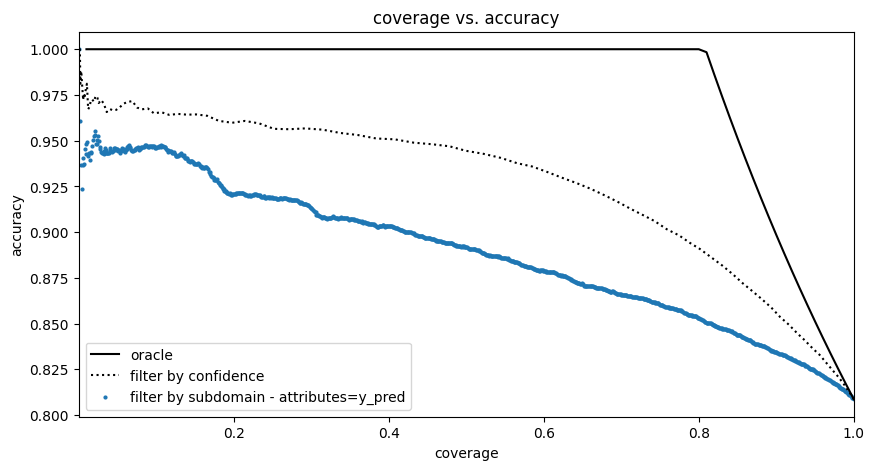

In [27]:
domain_cutoff_baseline = np.linspace(0.01, 1, 100)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = df_test['confidence'] > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df_test[idx_domain]['correct'].mean()

domain_cutoff_oracle = np.linspace(0.01, 1, 100)
coverage_oracle = np.zeros_like(domain_cutoff_oracle)
acc_oracle = np.zeros_like(domain_cutoff_oracle)
for i, cut in enumerate(domain_cutoff_oracle):
    idx_domain = df_test.sort_values(by='correct', ascending=False).index[:int(cut*len(df_test))]
    coverage_oracle[i] = cut
    acc_oracle[i] = df_test.loc[idx_domain]['correct'].mean()
    
# plot base
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')
ax1.plot(coverage_oracle, acc_oracle, c='k', label='oracle')
ax1.plot(coverage_baseline, acc_baseline, c='k', ls=':', label='filter by confidence')


coverage = np.zeros(len(df_test['subdomain_score'].unique()))
accuracy = np.zeros(len(df_test['subdomain_score'].unique()))
for i, cut in enumerate(sorted(df_test['subdomain_score'].unique(), reverse=True)):
    idx_domain = df_test['subdomain_score'] >= cut
    coverage[i] = idx_domain.mean()
    accuracy[i] = df_test[idx_domain]['correct'].mean()
ax1.scatter(coverage, accuracy, s=4, label=f'filter by subdomain - attributes=y_pred')

plt.legend()
ax1.set_xlim(0.0001, 1)

In [36]:
attributes = ['rain', 'sun']
prompts = ['it is raining', 'it is sunny']
text_input = torch.cat([clip_utils.tokenize(p) for p in prompts]).to(device)

for a in attributes:
    df[f'similarity_{a}'] = 0.
idx = 0
for batch in tqdm(dataloader_val):
    (x_classif, y_classif), (x_clip, y_clip) = batch
    assert (y_classif == y_clip).all(), "data for classifier and CLIP is not the same"
    batch_size = x_classif.shape[0]
    x_clip = x_clip.to(device)

    with torch.no_grad():
        image_features = clip.encode_image(x_clip)
        text_features = clip.encode_text(text_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T)

    for i, a in enumerate(attributes):
        df.loc[idx:idx+batch_size-1, f'similarity_{a}'] = similarity[:, i].cpu().numpy()

    idx += batch_size    

df.to_csv(path_results + '/logs_classif_val.csv')
print('CLIP logs saved')

100%|██████████| 49/49 [04:37<00:00,  5.66s/it]


CLIP logs saved


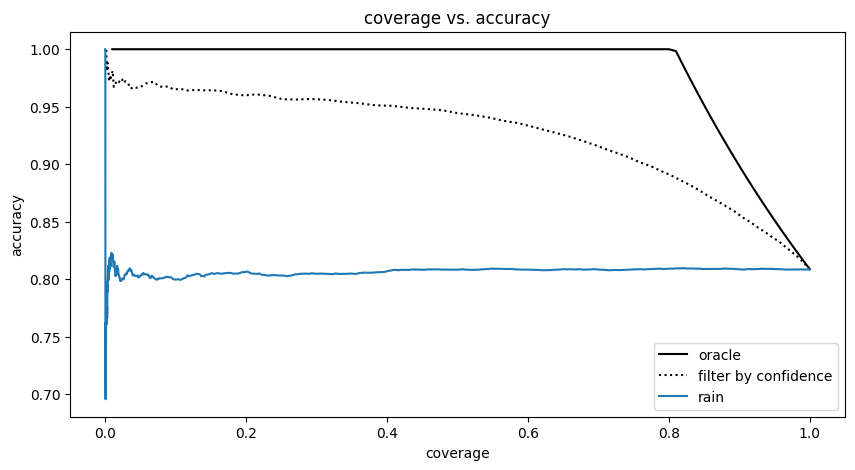

In [43]:
domain_cutoff_baseline = np.linspace(0.01, 1, 100)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = df_test['confidence'] > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df_test[idx_domain]['correct'].mean()

domain_cutoff_oracle = np.linspace(0.01, 1, 100)
coverage_oracle = np.zeros_like(domain_cutoff_oracle)
acc_oracle = np.zeros_like(domain_cutoff_oracle)
for i, cut in enumerate(domain_cutoff_oracle):
    idx_domain = df_test.sort_values(by='correct', ascending=False).index[:int(cut*len(df_test))]
    coverage_oracle[i] = cut
    acc_oracle[i] = df_test.loc[idx_domain]['correct'].mean()
    
# plot base
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')
ax1.plot(coverage_oracle, acc_oracle, c='k', label='oracle')
ax1.plot(coverage_baseline, acc_baseline, c='k', ls=':', label='filter by confidence')


# using attribute
a = 'rain'
domain_cutoff = np.linspace(df[f'similarity_{a}'].min(), df[f'similarity_{a}'].max(), 1000)
coverage = np.zeros_like(domain_cutoff)
risk = np.zeros_like(domain_cutoff)
acc = np.zeros_like(domain_cutoff)
for i, cut in enumerate(domain_cutoff):
    idx_domain = (df[f'similarity_{a}'] < cut)
    coverage[i] = idx_domain.mean()
    acc[i] = df.loc[idx_domain, 'well_classified'].mean()
ax1.plot(coverage, acc, label=a)

plt.legend()

(array([6.0000e+00, 1.1200e+02, 1.9390e+03, 1.1602e+04, 2.0858e+04,
        1.2064e+04, 2.9710e+03, 3.8500e+02, 5.1000e+01, 1.2000e+01]),
 array([10.125    , 11.9765625, 13.828125 , 15.6796875, 17.53125  ,
        19.3828125, 21.234375 , 23.0859375, 24.9375   , 26.7890625,
        28.640625 ]),
 <BarContainer object of 10 artists>)

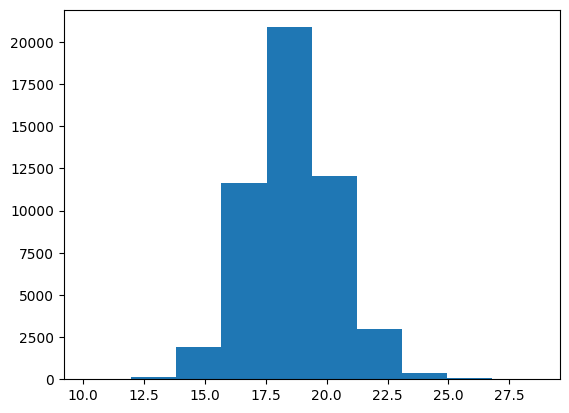

In [46]:
plt.figure()
plt.hist(df['similarity_rain'])